In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [6]:
data = sm.datasets.co2.load_pandas()
y = data.data

In [7]:
y = y['co2'].resample('MS').mean()
y = y.fillna(y.bfill())

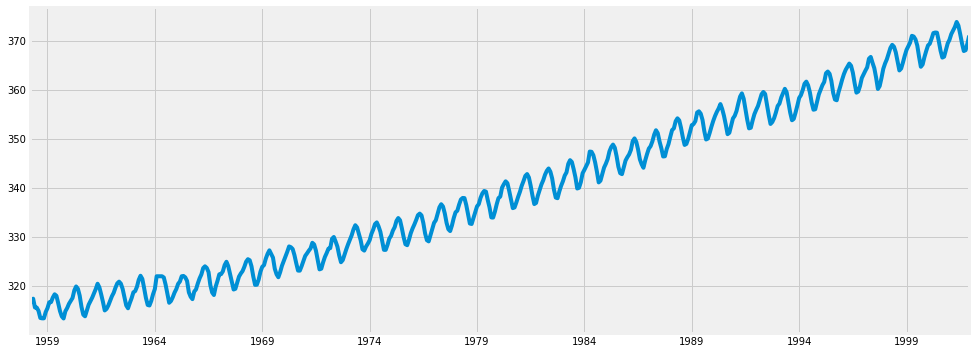

In [9]:
y.plot(figsize=(15, 6))
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

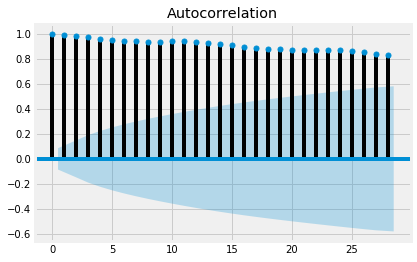

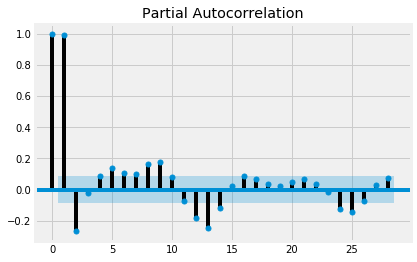

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(y)
plot_pacf(y)
plt.show

In [10]:

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
 
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
 
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [19]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
 
            results = mod.fit()
 
            print('ARIMA{}x{}12 - AIC:{}， BIC:{}'.format(param, param_seasonal, results.aic, results.bic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7612.583429881011， BIC:7616.846828143603
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.343624036742， BIC:6795.8241757270835
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1854.828234141261， BIC:1859.0685099864318
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.7111727636197， BIC:1605.1443849657894
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320026， BIC:1067.423338662913
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.287840438874， BIC:1069.0086679743863
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.6578978072075， BIC:1370.095098046591
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647912934656， BIC:1057.41460959672
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.048755206244， BIC:6889.571738574886
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.662327721806， BIC:6085.377301596925
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.1941066918753， BIC:1387.6707559419542
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.4174716848045， BIC:1254.061295980071
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1089.823162704791

In [13]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
 
results = mod.fit()
 
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.092      3.446      0.001       0.137       0.499
ma.L1         -0.6256      0.076     -8.178      0.000      -0.776      -0.476
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8767      0.026    -33.777      0.000      -0.928      -0.826
sigma2         0.0971      0.004     22.639      0.000       0.089       0.106


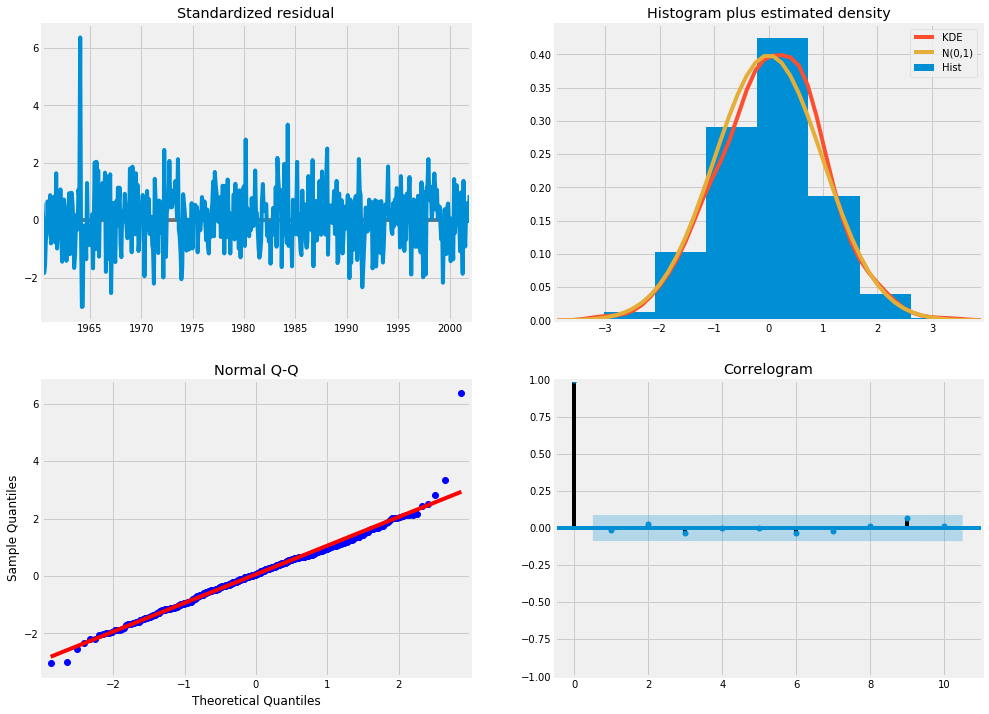

In [14]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [15]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

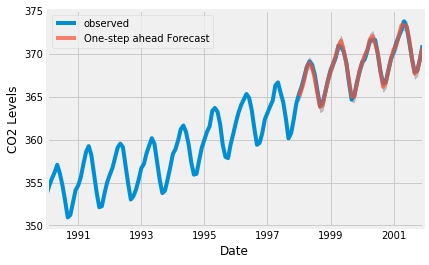

In [17]:

ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
 
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
 
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
 
plt.show()

In [18]:

y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]
 
# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


In [20]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)
 
# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

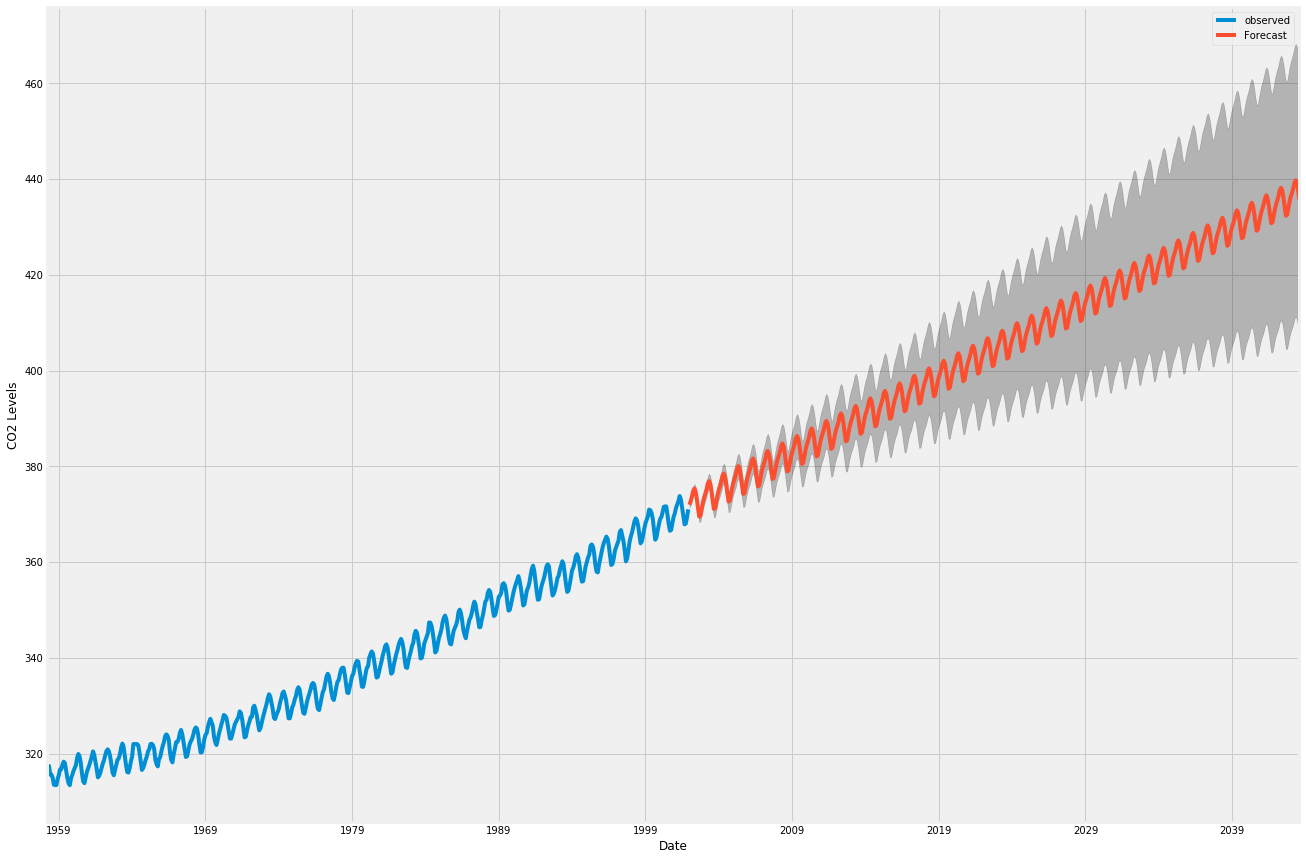

In [21]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
 
plt.legend()
plt.show()